<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_snippets
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 36.7MB 78kB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=a115fa47d9d1589770a9e44a93d5eb71890fbda661cd92a297d791aa6b61b384
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


In [ ]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval() 
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [ ]:
vgg = vgg19_modified().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
!wget https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
!wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

--2020-11-04 12:49:49--  https://www.dropbox.com/s/z1y0fy2r6z6m6py/60.jpg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/z1y0fy2r6z6m6py/60.jpg [following]
--2020-11-04 12:49:49--  https://www.dropbox.com/s/raw/z1y0fy2r6z6m6py/60.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucafd289f0976768196009ab2c29.dl.dropboxusercontent.com/cd/0/inline/BCiua8nqxIBZbZnuplfwgaPjkY9BijOWW5zdYXeRmEH0e3l1ZNCyDelMxefD4Uy280ncvactSbQsFOkPGuutIXPcbrRMzWGF4rmopfH0K-xqIA/file# [following]
--2020-11-04 12:49:50--  https://ucafd289f0976768196009ab2c29.dl.dropboxusercontent.com/cd/0/inline/BCiua8nqxIBZbZnuplfwgaPjkY9BijOWW5zdYXeRmEH0e3l1ZNCyDelMxefD4Uy280ncvactSbQsFOkPGuutIXPcbrRMzWGF4rmopfH0K-xqIA/file
Resolving ucafd289f0976768196009ab

In [ ]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [ ]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [ ]:
style_layers = [0, 5, 10, 19, 28] 
content_layers = [21]
loss_layers = style_layers + content_layers

In [ ]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [ ]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]] 
content_weights = [1]
weights = style_weights + content_weights

In [ ]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [ ]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [ ]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000	loss: 9652914.000	(247.12s - -0.98s remaining)

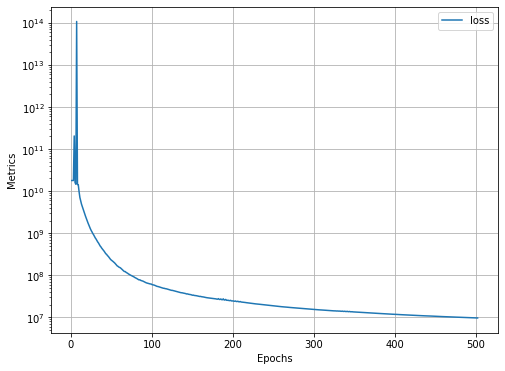

In [ ]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


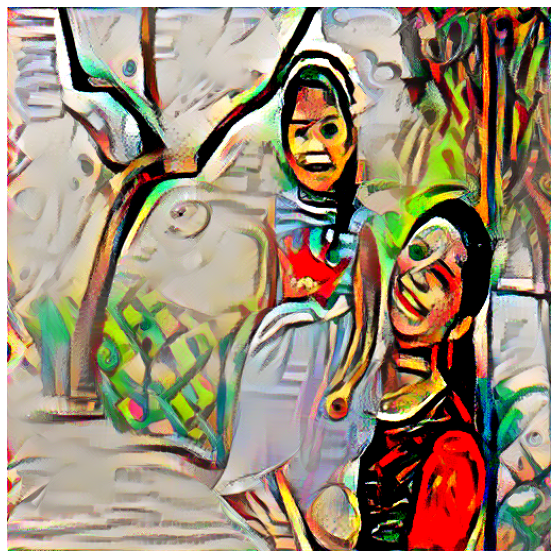

In [ ]:
out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)